In [1]:
import warnings
warnings.filterwarnings('ignore')

from yargy.interpretation import InterpretationEngine
from natasha import Combinator, Address
from natasha.grammars.location import AddressObject

from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns

import numpy as np
import pandas as pd

import requests
import json
import re

from tqdm import tqdm

In [2]:
c2a_filename = 'data_original/cache_comment2address.json'
a2g_filename = 'data_original/cache_address2geocode.json'

In [3]:
class ExtractAddresses:
    """
    класс с помощью либы natasha извлекает из 1 строчки текста список строчек с улицами
    * все преобразования кешируются в рамках одного объекта, кеш можно сохранять и загружать при создании нового объекта
    * кеш нужно сохранять принудительно после обработки нужного списка, .save_cache()
    * все площади фильтруются в данном примере, так как 99% упоминаний площадей не являются площадьми, кроме конкретных московских плоащдей. Их форма была получена прогоном нормальных названий площадей через этот класс
    * есть также некоторый блеклист улиц, которые удаляются
    """
    combinator = Combinator([Address])
    engine = InterpretationEngine(AddressObject)
    squares = {'автозаводская площадь', 'андроньевская площадь', 'арбатская площадь', 'биржевая площадь', 'болотная площадь', 'большая сухаревская площадь', 'боровицкая площадь', 'вешняковская площадь', 'вокзальная площадь', 'госпитальная площадь', 'грузинская площадь', 'даниловская площадь', 'дворцовая площадь', 'елоховская площадь', 'зацепская площадь', 'земляной вал', 'зубовская площадь', 'ивановская площадь', 'измайловская площадь', 'калужская площадь', 'комсомольская площадь', 'красная площадь', 'красноказарменная площадь', 'краснокурсантская площадь', 'крестьянская площадь', 'крымская площадь', 'лермонтовская площадь', 'лефортовская площадь', 'лубянская площадь', 'лялина площадь', 'малая сухаревская площадь', 'манежная площадь', 'миусская площадь', 'новая площадь', 'новоконная площадь', 'озёрная площадь', 'павелецкая площадь', 'песчаная площадь', 'площадь абельмановская', 'площадь академика', 'площадь академика вишневского', 'площадь академика келдыша', 'площадь академика курчатова', 'площадь академика петрова', 'площадь академика прохорова', 'площадь академика тамма', 'площадь амилкара кабрала', 'площадь арбатский ворота', 'площадь белы', 'площадь борьбы', 'площадь варварский ворота', 'площадь васильевский', 'площадь воровской', 'площадь гагарина', 'площадь ганецкий', 'площадь генерала жадова', 'площадь героев', 'площадь джавахарлала', 'площадь европы', 'площадь журавлёва', 'площадь защитников', 'площадь звёзд эстрады', 'площадь зденека', 'площадь индиры ганди', 'площадь иосипа броз тито', 'площадь киевский вокзал', 'площадь композитора балакирева', 'площадь космонавта комарова', 'площадь краснопресненская', 'площадь красный ворота', 'площадь курский вокзал', 'площадь мартина лютера кинга', 'площадь маршала бабаджаняна', 'площадь московско-минская дивизия', 'площадь новодевичий монастырь', 'площадь петровский ворота', 'площадь победы', 'площадь пречистенский ворота', 'площадь проломная', 'площадь раскова', 'площадь революции', 'площадь рогожская', 'площадь ромена роллана', 'площадь савёловский вокзал', 'площадь свободная россия', 'площадь серпуховская', 'площадь славы', 'площадь сретенский ворота', 'площадь тверская', 'площадь туманяна', 'площадь фиделя кастро', 'площадь цезаря куникова', 'площадь шарля', 'площадь эрнста тельмана', 'площадь яузский ворота', 'преображенская площадь', 'пушкинская площадь', 'рижская площадь', 'самотёчная площадь', 'севастопольская площадь', 'семёновская площадь', 'сенатская площадь', 'серпуховская площадь', 'славянская площадь', 'смоленская площадь', 'смоленская-сенная площадь', 'соборная площадь', 'сокольническая площадь', 'спартаковская площадь', 'спасопесковская площадь', 'старая площадь', 'суворовская площадь', 'таганская площадь', 'тверская площадь', 'театральная площадь', 'тишинская площадь', 'триумфальная площадь', 'трубная площадь', 'тургеневская площадь', 'тушинская площадь', 'университетская площадь', 'хитровская площадь', 'хохловская площадь'}
    streets_to_delete = {'расширения дорога', 'части улица', 'проездом строительная техника', 'новое дорога', 'открытое шоссе', 'наш измайловский проспект', 'домовладения ул .', 'весь проезд', 'ограниченного улица', 'общегородского значения проспект', 'проектирумый проезд', 'дома ул .', 'дорога ярославское направление', 'благоустройства набережная', 'общедоступный площади .', 'проезжая дорога', 'эта дорога', 'дорога районное значение', 'улучшения набережная', 'проектирумый проезд 317', 'близлежащий улица', 'широкополосная дорога', 'четырех-полосная дорога', 'хороший дорога', 'улица новая', 'моя улица'}

    def __init__(self, cache_filename=None):
        self.cache_filename = cache_filename
        if cache_filename:
            try:
                with open(cache_filename, encoding='utf8') as file:
                    self.cached_result = json.loads(file.read())
            except:
                self.cached_result = {}
                self.save_cache()
        else:
            self.cached_result = {}

    def save_cache(self):
        with open(self.cache_filename, 'w', encoding='utf8') as outfile:
            data = json.dumps(self.cached_result, ensure_ascii=False, sort_keys=True)
            outfile.write(data)
            
    def _filter_address(self, address_list):
        return list(set([a for a in address_list if a not in ExtractAddresses.streets_to_delete and ('площадь' not in a or a in ExtractAddresses.squares)]))

    def __call__(self, comment):
        comment = str(comment)
        if comment in self.cached_result:
            return self.cached_result[comment]
        natasha_result = list(ExtractAddresses.engine.extract(ExtractAddresses.combinator.resolve_matches(ExtractAddresses.combinator.extract(comment))))
        addresses = list(set([a.normalized for a in natasha_result]))
        self.cached_result.update({comment: addresses})
        return addresses

In [4]:
class GeocodeAddress:
    """
    класс переводит текстовую строчки с адресом (или список таких строк) в геометки с помощью Я.Декодер
    * все преобразования кешируются в рамках одного объекта, кеш можно сохранять и загружать при создании нового объекта
    * кеш нужно сохранять принудительно после обработки нужного списка, .save_cache()
    * здесь фильтруются только нужные города, лишние геометки не возвращаются
    """
    def __init__(self, cache_filename=None):
        self.cache_filename = cache_filename
        if cache_filename:
            try:
                with open(cache_filename, encoding='utf8') as file:
                    self.cached_result = json.loads(file.read())
            except:
                self.cached_result = {}
                self.save_cache()
        else:
            self.cached_result = {}

    def save_cache(self):
        with open(self.cache_filename, 'w', encoding='utf8') as outfile:
            data = json.dumps(self.cached_result, ensure_ascii=False, sort_keys=True)
            outfile.write(data)
            
    def _call_geocoder(self, address):
        response = requests.get(
            'http://geocode-maps.yandex.ru/1.x/',
            params={
                'format': 'json',
                'geocode': address
            }
        )
        return response
    
    def _parse_geocode_result(self, response):
        try:
            geo_object = response.json()['response']['GeoObjectCollection']['featureMember'][0]['GeoObject']
            geo_object_address = geo_object['metaDataProperty']['GeocoderMetaData']['Address']['Components']
            point_str = geo_object['Point']['pos']
            try:
                city = [i['name'] for i in geo_object_address if 'locality' in i.values()][0]
            except:
                city = None
            try:
                street = [i['name'] for i in geo_object_address if 'street' in i.values()][0]
            except:
                street = None
            try:
                house = [i['name'] for i in geo_object_address if 'house' in i.values()][0]
            except:
                house = None
            return {
                'coordinates': [float(t) for t in point_str.split()],
                'name': geo_object['name'],
                'city': city,
                'street': street,
                'house': house
            }
        except:
            return None
    
    def _filter_geocode(self, geocode):
        cities_interested_in = {'Москва', 'Балашиха', 'Видное', 'Долгопрудный', 'Зеленоград', 'Королёв', 'Красногорск', 'Люберцы', 'Мытищи', 'Одинцово', 'Реутов', 'Химки'}
        has_city = geocode and 'city' in geocode
        city_fits = has_city and geocode['city'] in cities_interested_in
        not_just_city = has_city and geocode['name'] not in cities_interested_in
        return geocode if has_city and city_fits and not_just_city else None

    def _make_geocode(self, address):
        if address in self.cached_result:
            return self.cached_result[address]
        geocode = self._filter_geocode(self._parse_geocode_result(self._call_geocoder(address)))
        self.cached_result.update({address: geocode})
        return geocode
    
    def __call__(self, address, filter_None = True):
        if not isinstance(address, list):
            return self._make_geocode(str(address))
        elif isinstance(address, list):
            address = list(set(address))
            r = [self._make_geocode(a) for a in address]
            if filter_None:
                r = [g for g in r if g]
                names = set()
                rr = []
                for i in r:
                    try:
                        if i['name'] not in names:
                            names.add(i['name'])
                            rr.append(i)
                    except:
                        print(r)
                        print(i)
                        1/0
            return rr

# Получаем геометки для ранее полученных данных

In [5]:
df = pd.read_excel('data_progress/3 PZZ.xlsx')

In [6]:
c2a = ExtractAddresses(cache_filename=c2a_filename)
a2g = GeocodeAddress(cache_filename=a2g_filename)

In [7]:
print(len(c2a.cached_result), len(a2g.cached_result))

29980 5411


*занимает ~ час без кэша, моментально с полным кэшем*

In [8]:
addresses = [c2a(c) for c in tqdm(df.comment)]
c2a.save_cache()

100%|██████████| 114011/114011 [00:00<00:00, 147348.66it/s]


*занимает ~ час без кэша, моментально с полным кэшем*

In [9]:
geocodes = [a2g(['Москва '+a for a in addresses_list]) for addresses_list in tqdm(addresses)]
a2g.save_cache()

100%|██████████| 114011/114011 [00:01<00:00, 81766.65it/s]


In [10]:
df['geocodes'] = geocodes

In [11]:
df['geocodes_number'] = df.geocodes.apply(len)

In [12]:
df.geocodes_number.value_counts().sort_index()

0     76646
1     19641
2      9084
3      4720
4      2717
5       802
6        55
7       218
8        19
9        19
10       20
11        5
12        3
13        4
14       28
15        1
16        2
17        3
18        1
21       16
22        2
23        1
24        1
25        1
26        1
27        1
Name: geocodes_number, dtype: int64

In [13]:
df.head()

,fio,comment,resolution,part,page,exact_page,orig_id,list_flag,fio_n,fio_n_popularity,...,comment_list_popularity,multiplier,comment_class_manual,resolution_class_manual,comment_class_prediction,resolution_class_prediction,comment_class,resolution_class,geocodes,geocodes_number
0,Захаренко В. А.,Во все разделы правил землепользования и застр...,"Предложения, относящиеся к предмету публичных ...",1,1,True,0,False,Захаренко В. А.,2.0,...,1,1,-1.0,-1.0,-1,-1,-1,-1,"[{'street': '1-й Самотёчный переулок', 'name':...",1
1,Калантарова Ю. В.,На основании вступившего в законную силу судеб...,"Предложения, относящиеся к предмету публичных ...",1,1,True,1,False,Калантарова Ю. В.,3.0,...,1,1,-1.0,-1.0,-1,-1,-1,-1,"[{'street': '1-й Самотёчный переулок', 'name':...",1
2,Ткач Е. В.,"В картах ПЗЗ не отражены ""Защитные зоны ОКН"" (...",Замечание рекомендовано к учёту. Рекомендовать...,1,5,True,2,False,Ткач Е. В.,4.0,...,1,1,-1.0,-1.0,-1,-1,-1,-1,[],0
3,Крупенина О. Н.,"На карте Градостроительного зонирования ""Грани...",1. Предложение предусмотрено проектом ПЗЗ. На ...,1,6,True,3,False,Крупенина О. Н.,1.0,...,1,1,1.0,-1.0,-1,-1,1,-1,[],0
4,Терехов А. С.,Внести в Проект правил землепользования и заст...,Предложение не рекомендовано к учёту. Отсутств...,1,6,True,4,False,Терехов А. С.,2.0,...,1,1,-1.0,-1.0,-1,-1,-1,-1,"[{'street': '2-й Обыденский переулок', 'name':...",1


In [14]:
df.to_excel('data_progress/4 PZZ.xlsx')

------

# Посмотрим на разнообразие полученных координат

In [15]:
from collections import Counter

In [16]:
geocodes_l = sum(df.geocodes,[])

In [17]:
geocodes_l[0]

{'city': 'Москва',
 'coordinates': [37.612416, 55.777454],
 'house': None,
 'name': '1-й Самотёчный переулок',
 'street': '1-й Самотёчный переулок'}

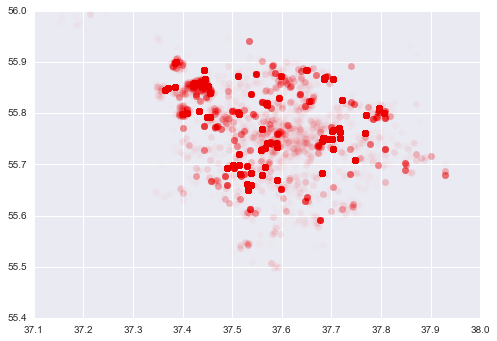

In [18]:
coordinates = [l['coordinates'] for l in geocodes_l if l]
x = [coordinate[0] for coordinate in coordinates]
y = [coordinate[1] for coordinate in coordinates]

plt.plot(x,y,'ro',alpha=0.01)

In [19]:
Counter([l['city'] for l in geocodes_l if l]).most_common()

[('Москва', 70324),
 ('Мытищи', 27),
 ('Зеленоград', 16),
 ('Химки', 6),
 ('Видное', 3),
 ('Балашиха', 2),
 ('Королёв', 2),
 ('Красногорск', 1),
 ('Долгопрудный', 1)]

In [20]:
Counter([g['house'] is not None for g in geocodes_l])

Counter({False: 55001, True: 15381})

In [21]:
Counter([g['street'] is not None for g in geocodes_l])

Counter({False: 140, True: 70242})

In [22]:
Counter([g['name'] for g in geocodes_l if g['street'] is None ]).most_common()

[('детский парк Фили', 57),
 ('жилой комплекс Воробьёв Дом', 44),
 ('монорельс Улица Милашенкова', 8),
 ('территория Дьяковское', 5),
 ('жилой комплекс Царская Площадь', 5),
 ('77-й квартал района Вешняки', 4),
 ('Курский вокзал', 3),
 ('Главный ботанический сад имени Н.В. Цицина Российской академии наук', 3),
 ('метро Улица Горчакова', 2),
 ('Киевский вокзал', 2),
 ('посёлок Ильинский', 2),
 ('район Проспект Вернадского', 1),
 ('жилой комплекс Родной город. Октябрьское Поле', 1),
 ('жилой квартал На Базовской', 1),
 ('комплекс жилых домов Сущёвка', 1),
 ('Новый сквер', 1)]

In [23]:
Counter([g['street'] for g in geocodes_l]).most_common()[:60]

[('Ленинградское шоссе', 7341),
 ('шоссе Энтузиастов', 4652),
 ('Живописная улица', 4256),
 ('улица Золоторожский Вал', 4235),
 ('11-я Парковая улица', 2879),
 ('мост Богдана Хмельницкого', 2804),
 ('Автомобильный проезд', 2741),
 ('улица Героев Панфиловцев', 2136),
 ('Волжский бульвар', 1583),
 ('Щёлковское шоссе', 1567),
 ('Парковая улица', 1560),
 ('улица Константина Федина', 1546),
 ('Солдатская улица', 1225),
 ('Пятницкое шоссе', 1070),
 ('Митинская улица', 1066),
 ('Таможенный проезд', 974),
 ('Профсоюзная улица', 974),
 ('улица Свободы', 959),
 ('1-й Земельный переулок', 771),
 ('Солдатский переулок', 702),
 ('Туристская улица', 677),
 ('Авиамоторная улица', 649),
 ('Боровая улица', 648),
 ('Юрьевский переулок', 648),
 ('Нахимовский проспект', 647),
 ('Таллинская улица', 511),
 ('Строгинское шоссе', 508),
 ('Мичуринский проспект', 493),
 ('Новопесчаная улица', 491),
 ('Новодевичий проезд', 490),
 ('Ленинский проспект', 476),
 ('Лосиноостровская улица', 469),
 ('Погодинская улица

------